In [1]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# finance datareader로부터 데이터 불러오기
data = fdr.DataReader('KS11')
data

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1981-05-01,123.60,123.60,123.60,123.60,3330000.0,0.0098
1981-05-02,123.50,123.50,123.50,123.50,2040000.0,-0.0008
1981-05-04,120.60,120.60,120.60,120.60,1930000.0,-0.0235
1981-05-06,120.70,120.70,120.70,120.70,1690000.0,0.0008
1981-05-07,119.30,119.30,119.30,119.30,1480000.0,-0.0116
...,...,...,...,...,...,...
2021-09-27,3133.64,3121.70,3146.35,3119.26,883230000.0,0.0027
2021-09-28,3097.92,3133.40,3134.46,3095.72,894910000.0,-0.0114
2021-09-29,3060.27,3055.50,3069.04,3030.60,821560000.0,-0.0122


In [7]:
# 종가만 추출
close = data['Close']

# 비교 기준 구간
start_date = '2021-09-01'
end_date = '2021-09-16'

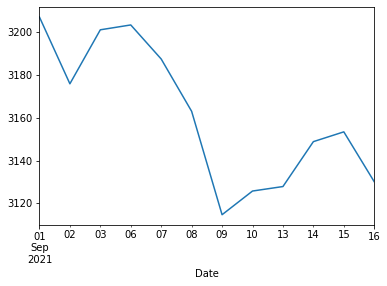

In [8]:
# 기준 구간 시계열 차트
close[start_date:end_date].plot();

In [9]:
base = close[start_date:end_date]
base

Date
2021-09-01    3207.02
2021-09-02    3175.85
2021-09-03    3201.06
2021-09-06    3203.33
2021-09-07    3187.42
2021-09-08    3162.99
2021-09-09    3114.70
2021-09-10    3125.76
2021-09-13    3127.86
2021-09-14    3148.83
2021-09-15    3153.40
2021-09-16    3130.09
Name: Close, dtype: float64

In [10]:
base_norm = (base - base.min()) / (base.max() - base.min())
base_norm

Date
2021-09-01    1.000000
2021-09-02    0.662370
2021-09-03    0.935442
2021-09-06    0.960030
2021-09-07    0.787695
2021-09-08    0.523072
2021-09-09    0.000000
2021-09-10    0.119801
2021-09-13    0.142548
2021-09-14    0.369692
2021-09-15    0.419194
2021-09-16    0.166703
Name: Close, dtype: float64

In [11]:
# 윈도우 사이즈
window_size = len(base)

# 예측 기간
next_date = 5

# 검색 횟수
moving_cnt = len(base) - window_size - next_date - 1

In [12]:
# 유사도 저장 딕셔너리
sim_list = []

for i in range(moving_cnt):
    target = close[i:i+window_size]
    
    # Normalize
    target_norm = (target - target.min()) / (target.max() - target.min())
    
    # 코사인 유사도 저장
    cos_similarity = cosine(base_norm, target_norm)
    
    # 코사인 유사도 <- i(인덱스), 시계열데이터 함께 저장
    sim_list.append(cos_similarity)

In [13]:
pd.Series(sim_list).sort_values().head(20)

Series([], dtype: float64)

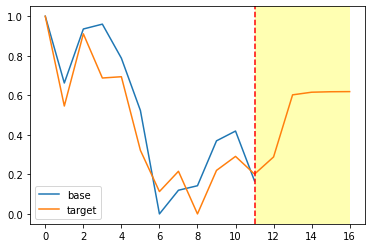

In [14]:
idx = 3193

top_ = close[idx:idx+window_size+next_date]
top_norm = (top_ - top_.min()) / (top_.max() - top_.min())

plt.plot(base_norm.values, label='base')
plt.plot(top_norm.values, label='target')
plt.axvline(x=len(base_norm)-1, c='r', linestyle='--')
plt.axvspan(len(base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
plt.legend()
plt.show()

In [15]:
class PatternFinder():
    def __init__(self, period=5):
        self.period = period
    
    def set_stock(self, code: str):
        self.code = code
        self.data = fdr.DataReader(code)
        self.close = self.data['Close']
        self.change = self.data['Change']
        return self.data
        
    def search(self, start_date, end_date, threshold=0.98):
        base = self.close[start_date:end_date]
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base
        
        display(base)
        
        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.period - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)
        
        self.window_size = window_size
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims
    
    
    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        # 유사도 저장 딕셔너리
        sim_list = []

        for i in range(moving_cnt):
            target = self.close[i:i+window_size]

            # Normalize
            target_norm = (target - target.min()) / (target.max() - target.min())

            # 코사인 유사도 저장
            cos_similarity = cosine_similarity(self.base_norm, target_norm)

            # 코사인 유사도 <- i(인덱스), 시계열데이터 함께 저장
            sim_list.append(cos_similarity)
        return pd.Series(sim_list).sort_values(ascending=False)

    
    def plot_pattern(self, idx, period=5):
        if period != self.period:
            self.period = period
            
        top = self.close[idx:idx+self.window_size+period]
        top_norm = (top - top.min()) / (top.max() - top.min())

        plt.plot(self.base_norm.values, label='base')
        plt.plot(top_norm.values, label='target')
        plt.axvline(x=len(self.base_norm)-1, c='r', linestyle='--')
        plt.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        plt.legend()
        plt.show()
        
        preds = self.change[idx+self.window_size: idx+self.window_size+period]
        display(preds)
        print(f'pred: {preds.mean()*100} % ')

In [16]:
p = PatternFinder()

In [17]:
p.set_stock('018700')

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-09-09,141661,141661,141661,141662,0,NaN
1997-09-10,132231,132231,132231,132235,0,-0.066546
1997-09-11,142618,142618,125623,125610,1010,-0.050100
1997-09-12,135048,135048,120882,120882,1010,-0.037640
1997-09-13,130328,130328,123726,123713,1010,0.023420
...,...,...,...,...,...,...
2021-09-27,2925,3080,2860,2955,2126291,0.026042
2021-09-28,2915,3150,2910,2995,2982253,0.013536
2021-09-29,2900,3035,2845,2975,787362,-0.006678


In [18]:
result = p.search('2021-09-10', '2021-09-30')

Date
2021-09-10    2625
2021-09-13    2620
2021-09-14    2630
2021-09-15    2625
2021-09-16    2635
2021-09-17    2635
2021-09-23    2920
2021-09-24    2880
2021-09-27    2955
2021-09-28    2995
2021-09-29    2975
2021-09-30    3020
Name: Close, dtype: int64

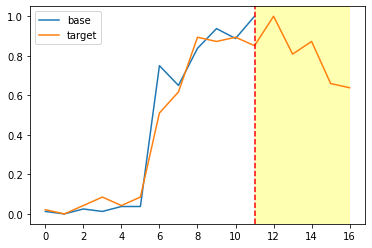

Date
2006-03-07    0.040917
2006-03-08   -0.050551
2006-03-09    0.017761
2006-03-10   -0.058170
2006-03-13   -0.006176
Name: Change, dtype: float64

pred: -1.1243734433432984 % 


In [19]:
p.plot_pattern(2138)

## 웹으로 만들기

In [20]:
import ipywidgets as widgets
from IPython.display import display, clear_output

!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter serverextension enable voila --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
Enabling: voila
- Writing config: c:\users\teddy\anaconda3\envs\stock-pattern\etc\jupyter
    - Validating...
      voila 0.2.15 ok


In [21]:
start_date = widgets.DatePicker(description='시작일')
end_date = widgets.DatePicker(description='종료일')

In [22]:
# button send
search_button = widgets.Button(
                description='예측하기',
                tooltip='Send',
                style={'description_width': 'initial'}
            )

output = widgets.Output()

def on_button_clicked(event):
    with output:
        clear_output()
        p = PatternFinder()
        p.set_stock(code.value)
        result = p.search(start_date.value.strftime('%Y-%m-%d'), end_date.value.strftime('%Y-%m-%d'))
        print(result)
        for idx in result.keys():
            p.plot_pattern(idx)
        
search_button.on_click(on_button_clicked)

vbox_result = widgets.VBox([search_button, output])

In [23]:
label_headline = widgets.Label(
                    value='Photo by CDC on Unsplash',
                )

vbox_headline = widgets.VBox([label_headline])

In [24]:
text_0 = widgets.HTML(value="<h2>종목 코드</h2>")
text_1 = widgets.HTML(value="<h2>날짜 선택</h2>")
text_2 = widgets.HTML(value="<h2>패턴 예측</h2>")

code = widgets.Text(placeholder='종목코드를 입력해 주세요')
code.value = '035720'

vbox_0 = widgets.VBox([text_0, code])
vbox_1 = widgets.VBox([text_1,start_date, end_date ])
vbox_2 = widgets.VBox([text_2, vbox_result])

In [25]:
page = widgets.VBox([vbox_0, vbox_1 , vbox_2])
display(page)